# Predict the Critical Temperature of a Superconductor with Random Forest
This notebook will reproduce and improve the Random Forest results of `predict_tc` in the Python language.

The paper makes these points about random forest implementation.

> Scalability and speed are important advantages of using XGBoost over random forests

In [ ]:
# Install `pyCHNOSZ` if not installed already.
!pip install pyCHNOSZ

In [2]:
import numpy as np
import pickle
import pyCHNOSZ
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from xgboost import XGBRegressor

# Local Modules
from pyplot_data import plot_observed_vs_predicted
from read_data import load_and_split

>**Out-Of_sample RMSE Estimation Procedure**
>1. At random divide the data into 2/3 train and 1/3 test data.

In [3]:
training_X, training_y, testing_X, testing_y = load_and_split()

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


>2. Fit the model using the train data.

The paper mentions that the model with the lowest out-of-sample rmse was obtained with the following parameters.
>$\eta$ = 0.02, maximum depth = 16, minimum child weight = 1, column subsampling = 0.50, and a tree size of 374.

We will first train a model with these parameters.

In [6]:
xgb_lowest_rmse = XGBRegressor(
    learning_rate = 0.02,
    max_depth = 16,
    min_child_weight = 1,
    n_estimators=374,
    colsample_bytree=0.5,
    colsample_bylevel=0.5,
    colsample_bynode=0.5
)
xgb_lowest_rmse.fit(training_X, training_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.02, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=16, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=374, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [10]:
# Load Model
with open("../models/xgb_lowest_rmse.pkl", "rb") as f:
    xgb_lowest_rmse = pickle.load(f)

In [8]:
# Save Model
with open("../models/xgb_lowest_rmse.pkl", "wb") as f:
    pickle.dump(xgb_lowest_rmse, f)

>3. Predict $T_c$ of the test data.

Score: 0.9230259263366578


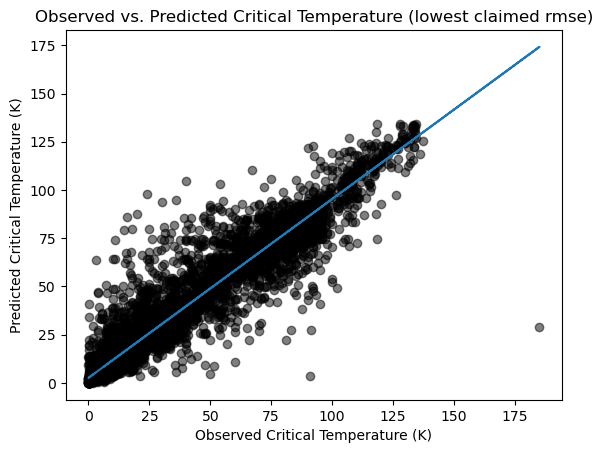

In [11]:
# Generates prediction using xgboost.
prediction_xgb_lowest_rmse = xgb_lowest_rmse.predict(testing_X)

print(f"Score: {xgb_lowest_rmse.score(testing_X, testing_y)}")

plot_observed_vs_predicted(
    testing_y,
    prediction_xgb_lowest_rmse,
    title="Observed vs. Predicted Critical Temperature (lowest claimed rmse)"
)

> 4. Obtain an estimate of the out-of-sample mean-squared-error (mse) by using the predictions from the last step and the observed $T_c$ values in the test data:
>$$out\;of\;sample\;mse=Average\;of\;(observed-predicted)^2$$

In [12]:
def out_of_sample_mse(labels, prediction):
    """
    Determines the out of sample mean squared error.
    """
    return np.average(np.square(labels - prediction))

In [13]:
mse_xgb_lowest_rmse = out_of_sample_mse(testing_y, prediction_xgb_lowest_rmse)

print(f"Current MSE: {mse_xgb_lowest_rmse}")

Current MSE: 2247.344494866849


> 5. Repeat steps 1 through 4, 25 times to collect 25 out-of-sample mse's.

In [14]:
mse_xgb_lowest_rmse_values = []
for index in tqdm(range(25)):
    training_X, training_y, testing_X, testing_y = load_and_split(random_state=index)
    xgb_lowest_rmse = XGBRegressor(
        learning_rate = 0.02,
        max_depth = 16,
        min_child_weight = 1,
        n_estimators=374,
        colsample_bytree=0.5,
        colsample_bylevel=0.5,
        colsample_bynode=0.5
    )
    xgb_lowest_rmse.fit(training_X, training_y)
    mse_xgb_lowest_rmse_values.append(out_of_sample_mse(testing_y, prediction_xgb_lowest_rmse))


  0%|          | 0/25 [00:00<?, ?it/s]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


  4%|▍         | 1/25 [06:02<2:25:07, 362.81s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


  8%|▊         | 2/25 [12:04<2:18:48, 362.12s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 12%|█▏        | 3/25 [17:55<2:10:56, 357.12s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 16%|█▌        | 4/25 [23:48<2:04:25, 355.50s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 20%|██        | 5/25 [29:27<1:56:33, 349.67s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 24%|██▍       | 6/25 [35:13<1:50:19, 348.39s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 28%|██▊       | 7/25 [40:58<1:44:06, 347.01s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 32%|███▏      | 8/25 [46:16<1:35:43, 337.88s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 36%|███▌      | 9/25 [5:16:49<23:35:12, 5307.02s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 40%|████      | 10/25 [5:22:23<15:42:53, 3771.57s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 44%|████▍     | 11/25 [5:27:58<10:34:40, 2720.07s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 48%|████▊     | 12/25 [5:33:27<7:11:43, 1992.61s/it] 

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 52%|█████▏    | 13/25 [5:38:59<4:57:55, 1489.63s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 56%|█████▌    | 14/25 [5:44:36<3:29:14, 1141.34s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 60%|██████    | 15/25 [5:49:52<2:28:46, 892.67s/it] 

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 64%|██████▍   | 16/25 [5:55:09<1:47:54, 719.37s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 68%|██████▊   | 17/25 [6:00:53<1:20:52, 606.52s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 72%|███████▏  | 18/25 [6:06:34<1:01:26, 526.61s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 76%|███████▌  | 19/25 [6:11:58<46:35, 465.85s/it]  

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 80%|████████  | 20/25 [6:17:25<35:20, 424.13s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 84%|████████▍ | 21/25 [6:22:50<26:17, 394.42s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 88%|████████▊ | 22/25 [6:28:45<19:07, 382.45s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 92%|█████████▏| 23/25 [6:34:33<12:24, 372.07s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


 96%|█████████▌| 24/25 [6:40:01<05:59, 359.04s/it]

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


100%|██████████| 25/25 [6:45:27<00:00, 973.10s/it]


> 6. Take the mean of the 25 collected out-of-sample mse's and report the square root of this average as the final estimate of the out-of-sample-rmse.

In [15]:
print(f"XGBoost RMSE: {np.sqrt(np.mean(mse_xgb_lowest_rmse_values))}")

XGBoost RMSE: 47.51016795227898
